# California housing data set

I'm going to train an SVM regressor on the California housing data set. The data set can be found at [Aurélien Geron's GitHub web site](https://github.com/ageron/handson-ml/tree/master/datasets/housing). The README at the web site gives a good explanation of the data set.

Let's start by doing some exploratory data analysis.

 - [Exploratory data analysis](#Exploratory-data-analysis)
   - [Looking for correlations](#Looking-for-correlations)
 - [Model pipeline](#Model-pipeline)
   - [SVM regressor](#SVM-regressor)
   - [LinearSVR](#LinearSVR)
   - [SVR](#SVR)

## Exploratory data analysis

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [3]:
PROJECT_ROOT_DIR = '/Users/angelo/Programming/Python/ageron-hands-on-machine-learning'
file_name = os.path.join(PROJECT_ROOT_DIR, 'datasets/housing/housing.csv')

In [4]:
housing_df = pd.read_csv(file_name)
category = list(housing_df.select_dtypes('object').columns)
housing_df[category] = housing_df[category].astype('category')
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null category
dtypes: category(1), float64(9)
memory usage: 1.4 MB


In [6]:
housing_df.isnull().sum()

longitude             0  
latitude              0  
housing_median_age    0  
total_rooms           0  
total_bedrooms        207
population            0  
households            0  
median_income         0  
median_house_value    0  
ocean_proximity       0  
dtype: int64

We can see that there are 207 null values for the `total_bedrooms` feature. We will need to address this, and one way is to use the median to fill in the null values for example.

In [7]:
housing_df.describe().applymap('{:.2f}'.format)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.00,20640.00,20640.00,20640.00,20433.00,20640.00,20640.00,20640.00,20640.00
mean,-119.57,35.63,28.64,2635.76,537.87,1425.48,499.54,3.87,206855.82
std,2.00,2.14,12.59,2181.62,421.39,1132.46,382.33,1.90,115395.62
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,14999.00
25%,-121.80,33.93,18.00,1447.75,296.00,787.00,280.00,2.56,119600.00
50%,-118.49,34.26,29.00,2127.00,435.00,1166.00,409.00,3.53,179700.00
75%,-118.01,37.71,37.00,3148.00,647.00,1725.00,605.00,4.74,264725.00
max,-114.31,41.95,52.00,39320.00,6445.00,35682.00,6082.00,15.00,500001.00


In [8]:
housing_df.nunique()

longitude             844  
latitude              862  
housing_median_age    52   
total_rooms           5926 
total_bedrooms        1923 
population            3888 
households            1815 
median_income         12928
median_house_value    3842 
ocean_proximity       5    
dtype: int64

In [9]:
housing_df.ocean_proximity.unique()

[NEAR BAY, <1H OCEAN, INLAND, NEAR OCEAN, ISLAND]
Categories (5, object): [NEAR BAY, <1H OCEAN, INLAND, NEAR OCEAN, ISLAND]

Let's generate a pairwise grid plot for some of the numerical features in the data set. We'll plot the geographic coordinates in the next plot.

/Applications/Computation/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Applications/Computation/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


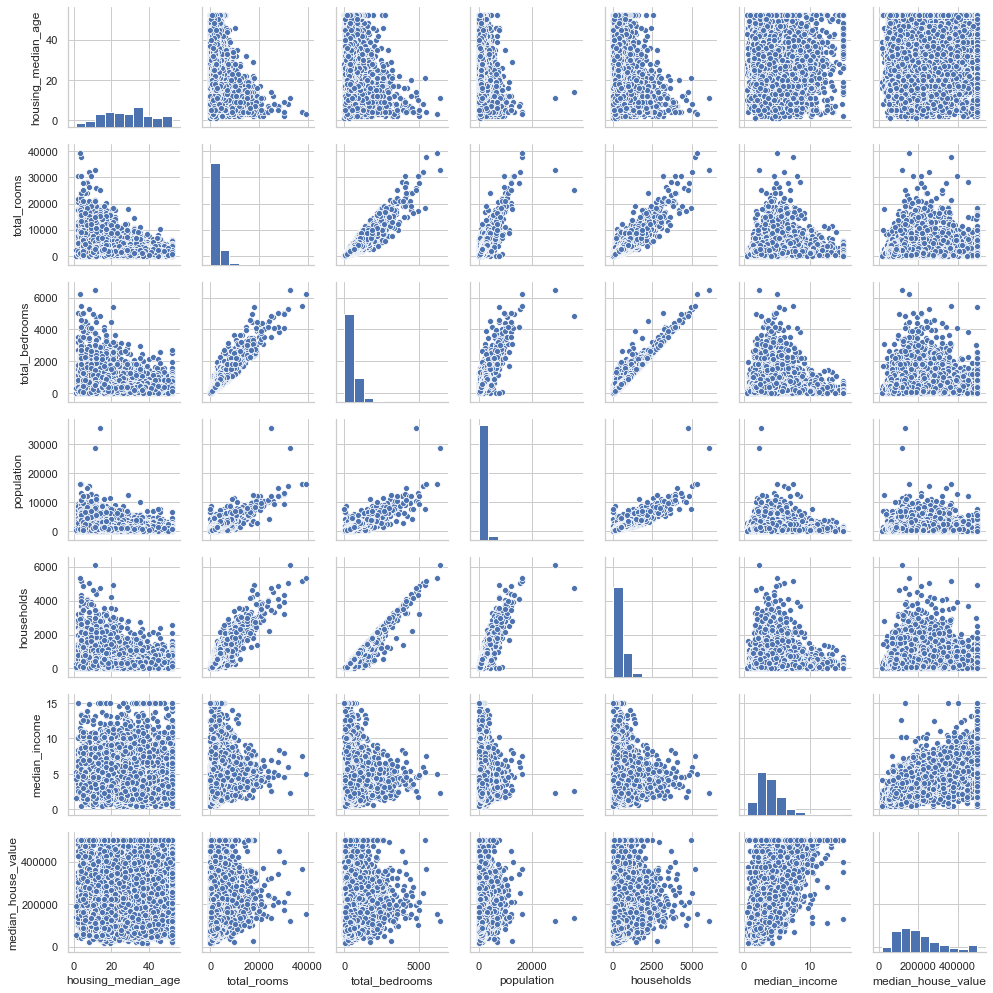

In [10]:
sns.set(style="whitegrid")
cols = housing_df.columns[2:-1]
sns.pairplot(data=housing_df[cols], kind='scatter', diag_kind='hist', height=2)
plt.tight_layout();

Here we can see the geographical districts color-coded for median house price. The San Francisco bay area and the greater Los Angeles / San Diego area are notoriously expensive.

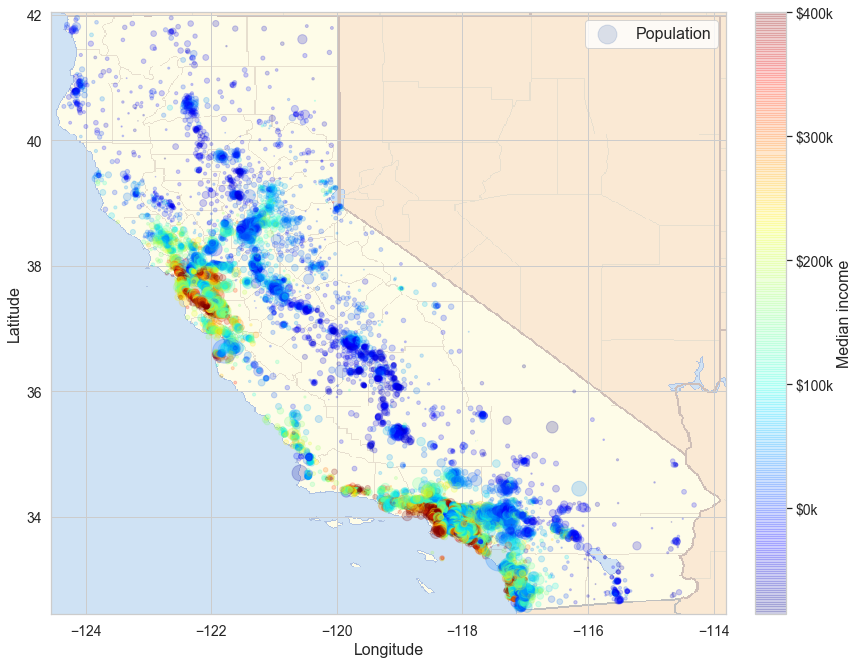

In [11]:
import matplotlib.image as mpimg
img_name = os.path.join(PROJECT_ROOT_DIR, 'images/end_to_end_project/california.png')
california_img = mpimg.imread(img_name)

fig, axes = plt.subplots(1, 1, figsize=(12, 10))
lat, long, pop, med_price = housing_df.iloc[:, 0], housing_df.iloc[:, 1], housing_df.iloc[:, 5], housing_df.iloc[:, -2]
g = axes.scatter(lat, long, c=med_price, s=pop/50, cmap=plt.cm.jet, alpha=0.2, label='Population')

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5, cmap=plt.cm.jet)

plt.ylabel("Latitude", fontsize=16)
plt.xlabel("Longitude", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

tick_values = np.arange(0, med_price.max(), 1e5)
cbar = plt.colorbar(g, fraction=0.041, pad=0.04)
cbar.ax.set_yticklabels(['{}{:.0f}{}'.format('$', np.around(v/1000), 'k') for v in tick_values], fontsize=14)
cbar.set_label('Median income', fontsize=16)

plt.legend(loc='best', fontsize=16)
plt.tight_layout();

### Looking for correlations

In [12]:
corr_df = housing_df[cols].corr()

In [13]:
corr_df.median_house_value[np.abs(corr_df.median_house_value)<1].sort_values(ascending=False)

median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
Name: median_house_value, dtype: float64

As we can see, the median income is strongly correlated with the median house value. It is followed in second place by total number of rooms, but it isn't as strongly correlated as median house value.

## Model pipeline

In [14]:
X = housing_df.drop(['latitude', 'longitude', 'median_house_value'], axis=1)
y = housing_df['median_house_value'].values

In [15]:
cat_attrib = X.select_dtypes('category').columns
num_attrib = X.select_dtypes('float64').columns
print(cat_attrib)
print(num_attrib)

Index(['ocean_proximity'], dtype='object')
Index(['housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
       'households', 'median_income'],
      dtype='object')


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [17]:
imputer = SimpleImputer(strategy='median')
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('std_scaler', StandardScaler())])
full_pipeline = ColumnTransformer([('num', num_pipeline, num_attrib), ('cat', OneHotEncoder(), cat_attrib)])

### SVM regressor
#### LinearSVR

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR, SVR

In [19]:
X_prepared = full_pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size = 0.3, random_state=42)

In [32]:
print(np.isnan(X_prepared).any())
print(X_prepared.shape)

False
(20640, 11)


In [92]:
lin_svr = LinearSVR(C=1.0, loss='squared_epsilon_insensitive', max_iter=1e5, tol=0.0001, random_state=42)

In [93]:
lin_svr.fit(X_train, y_train)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='squared_epsilon_insensitive',
          max_iter=100000.0, random_state=42, tol=0.0001, verbose=0)

In [94]:
print(f'R-squared of LinearSVR on test set: {lin_svr.score(X_test, y_test):.4f}')

R-squared of the SVM regressor on test set: 0.6288


#### SVR

In [218]:
svr = SVR(gamma='auto', kernel='linear', C=1000)

In [219]:
svr.fit(X_train, y_train)

SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [220]:
print(f'R-squared of SVR on test set: {svr.score(X_test, y_test):.4f}')

R-squared of SVR on test set: 0.6145
